# Skeleton to 2D images

Transform the data from 3d points skeleton to 2d images with depth

## Load data

In [10]:
cd data/nturgbd_skeletons_s001_to_s017/

C:\Users\Intel\Documents\@M2\Idemia\human-action-recognition\data\nturgbd_skeletons


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageDraw
import os
from tqdm import tqdm

In [4]:
bust_joints = [0, 1, 20, 2, 3]
right_arm_joint = [23, 24, 11, 10, 9, 8]
left_arm_joint = [21, 22, 7, 6, 5, 4]
arm_joints = [23, 24, 11, 10, 9, 8, 20, 4, 5, 6, 7, 22, 21]
right_leg_joints = []
left_leg_joints = []
leg_joints = [19, 18, 17, 16, 0, 12, 13, 14, 15]

body_joints = [bust_joints, arm_joints, leg_joints]

In [5]:
def get_skeleton_info(file):
    """
    Read the .skeleton files and process the data
    
    Example of output:
    {'numb_of_frames': 103, 
     'frame_info': [{'numb_of_skeletons': 1, 
                     'skeleton_info': [{'numb_of_joints': 25, 
                                        'joint_info': [{'x': 0.2181153, 'y': 0.1725972, 'z': 3.785547, 
                                                        'depthX': 277.419, 'depthY': 191.8218, 
                                                        'colorX': 1036.233, 'colorY': 519.1677, 
                                                        'orientationW': -0.2059419, 'orientationX': 0.05349901, 
                                                        'orientationY': 0.9692109, 'orientationZ': -0.1239193, 
                                                        'trackingState': 2.0}, 
                                                       {'x': 0.2323292, 'y': 0.4326636, 'z': 3.714767, ...} ...]
    """

    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numb_of_frames'] = int(f.readline())
        skeleton_sequence['frame_info'] = []
        # typically: skeleton_sequence = {'numb_of_frames': 103, 'frame_info': []}

        for frame in range(skeleton_sequence['numb_of_frames']):
            frame_info = {}
            frame_info['numb_of_skeletons'] = int(f.readline())
            frame_info['skeleton_info'] = []
            # typically: frame_info = {'numb_of_skeletons': 1, 'skeleton_info': []}

            for m in range(frame_info['numb_of_skeletons']):
                #print(f"    \u21FE m = {m}")
                skeleton_info = {}
                skeleton_info_key = ['bodyID', 'clipedEdges', 'handLeftConfidence','handLeftState', 'handRightConfidence', 'handRightState','isResticted', 'leanX', 'leanY', 'trackingState']
                skeleton_info_info = {
                    k: float(v)
                    for k, v in zip(skeleton_info_key, f.readline().split())
                }
                skeleton_info['numb_of_joints'] = int(f.readline())
                skeleton_info['joint_info'] = []
                #print(f"    \u25AA skeleton_info = {skeleton_info}")

                for v in range(skeleton_info['numb_of_joints']):
                    joint_info_key = ['x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY','orientationW', 'orientationX', 'orientationY','orientationZ', 'trackingState']
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    skeleton_info['joint_info'].append(joint_info)
                frame_info['skeleton_info'].append(skeleton_info)
                #print(f"skeleton_info = {skeleton_info}")

            skeleton_sequence['frame_info'].append(frame_info)
            #print(f"skeleton_sequence = {skeleton_sequence}")
    return skeleton_sequence

def get_pixels(skeleton):
    data = np.zeros((skeleton['numb_of_frames'], 25, 3))  # (3,frame_nums,25 2)
    for n, f in enumerate(skeleton['frame_info']):
        for m, b in enumerate(f['skeleton_info']):
            for j, v in enumerate(b['joint_info']):
                if j < 25:
                    data[n, j] = [int(v['colorX']), int(v['colorY']), v['z']]
                else:
                    pass
    #print(f"\u25A0 data = {data}\ndata.shape = {data.shape}")
#     np.save("./data_to_get_rid_of", data)
    return data


def normalize_z(skeleton):
    # get pixels but also normalize the depth between 0 and 1
    sklt_pixels = get_pixels(skeleton)
    mini = sklt_pixels[:,:,2].min()
    maxi = sklt_pixels[:,:,2].max()
#     print(maxi)
    sklt_pixels[:,:,2] = (sklt_pixels[:,:,2]-mini)/(maxi-mini)
    return sklt_pixels

1.0


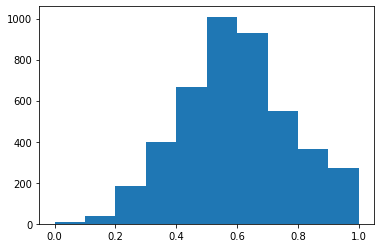

In [111]:
skeleton = get_skeleton_info('S001C001P001R001A015.skeleton')
sklt_pixels = get_pixels(skeleton)
sklt_pixels = normalize_z(skeleton)
print(sklt_pixels[:,:,2].max())
plt.hist(sklt_pixels[:,:,2].flatten())
plt.show()

## Create Image

In [112]:
body_joints

[[0, 1, 20, 2, 3],
 [23, 24, 11, 10, 9, 8, 20, 4, 5, 6, 7, 22, 21],
 [19, 18, 17, 16, 0, 12, 13, 14, 15]]

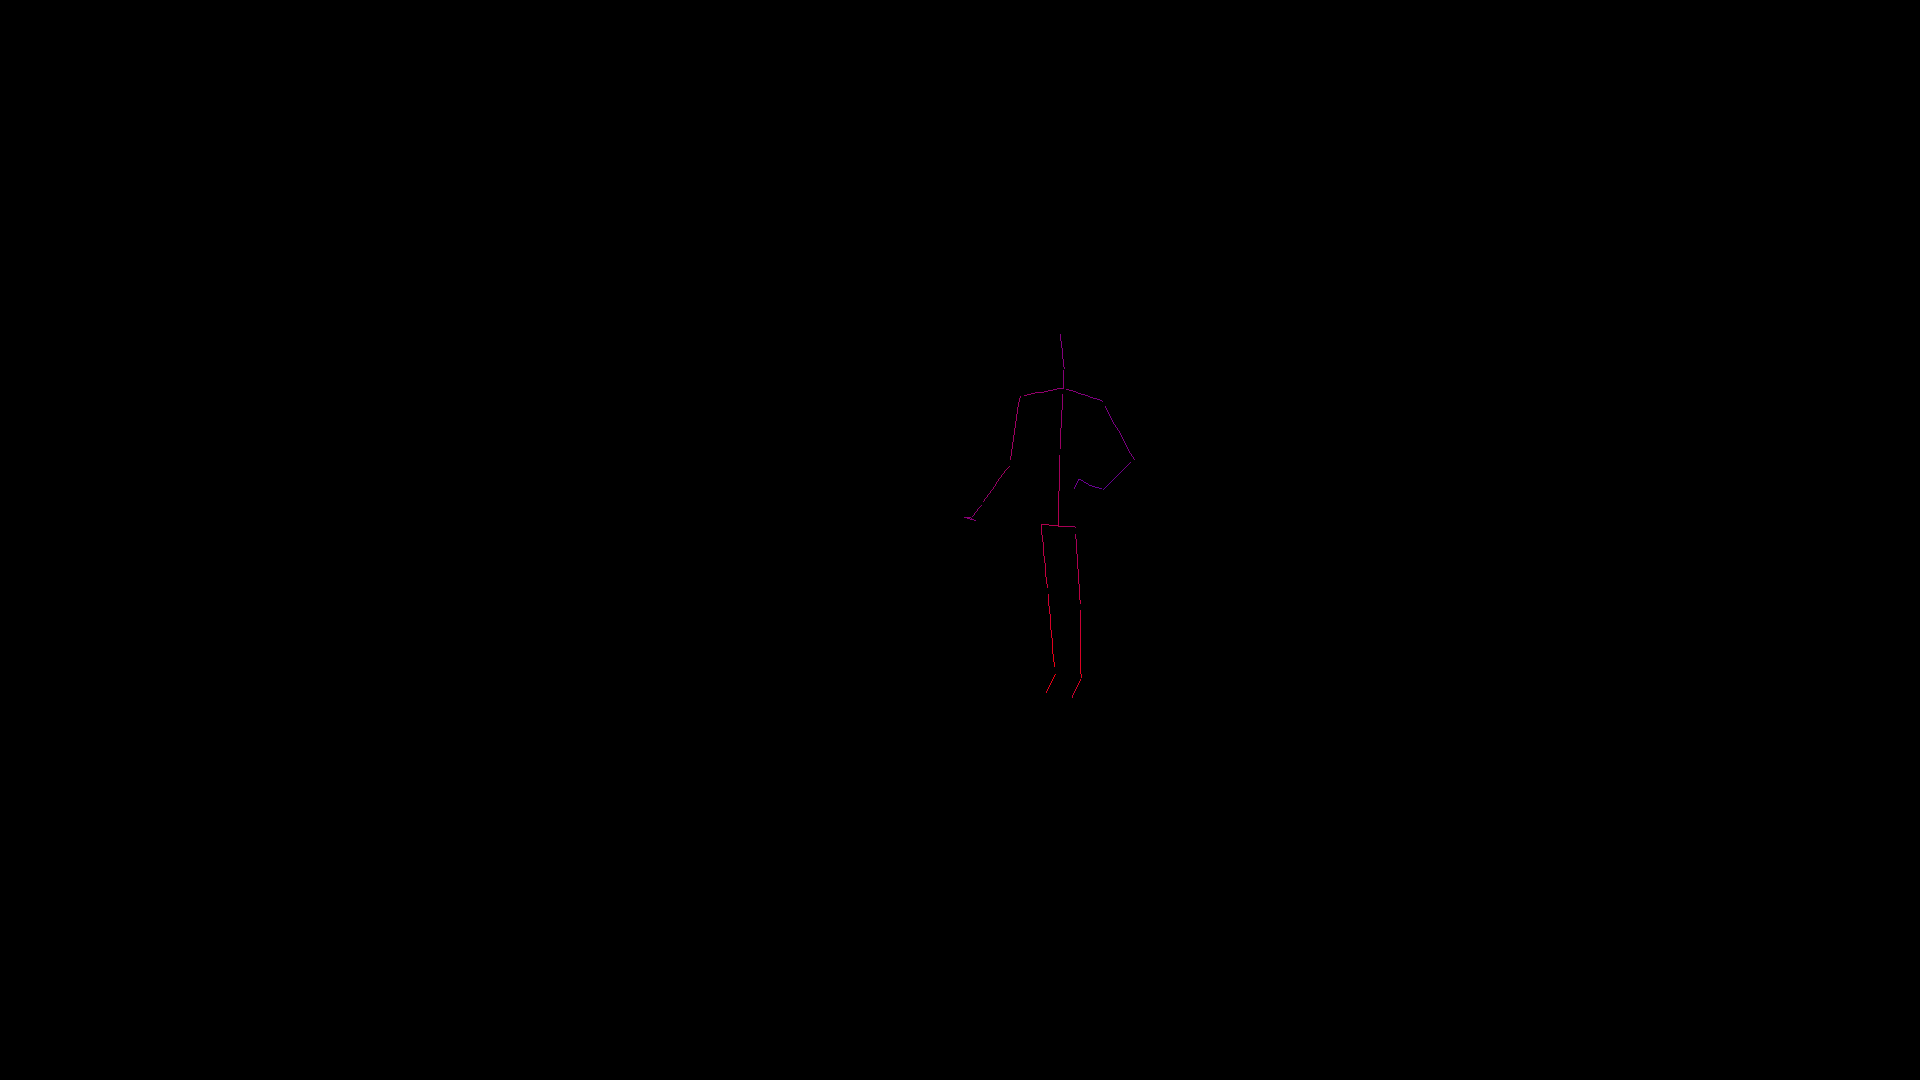

In [113]:
def create_sklt(frame):
    # create the skeleton for a given frame
    img = Image.new('RGB', (1920,1080 ), color = 'black')
    for body_part in body_joints:
#         ind_to_pixels = [tuple(frame[body_part[i]][:2]) for i in range(len(body_part))]
#         draw = ImageDraw.Draw(img)
#         draw.line(ind_to_pixels,fill=(255,0,0),width=5)
        for i in range(len(body_part)-1):
            a = frame[body_part[i]]
            b = frame[body_part[i+1]]-a
            n = 10
#             print('a:',a)
#             print(b)
#             print(a+(i/n)*b
#             break
            line = np.array([a+(i/n)*b for i in range(n)])
            for i in range(len(line)-1):
                x1,y1,z = line[i]
                x2,y2,_ = line[i+1]
#                 img.putpixel((int(x),int(y)), (255,255,255))
                draw = ImageDraw.Draw(img)
                color = tuple((int(255*z),0,int(255*(1-z))))
#                 color = (255,255,255)
#                 print(color)
                draw.line((x1,y1,x2,y2), fill=color,width=5)

#     for joint in frame:
#         x,y,z = joint
#         img.putpixel((int(x),int(y)), (255,255,255))
    return img

img = create_sklt(sklt_pixels[0,:,:])
img

In [114]:
def create_gif(name,sklt_pixels):
    seq = [create_sklt(frame) for frame in sklt_pixels]
    seq[0].save(name,save_all=True,append_images=seq[1:])

In [115]:
create_gif('2d_skeleton_A015.gif',sklt_pixels)

### Test manual projection

In [ ]:
CameraToWorld = np.eye(4)
Rot = R.from_euler("XYZ",[0,0,0], degrees=True).as_matrix()
# CameraToWorld[0,:] = [0.718762, 0.615033, -0.324214, 0]
# CameraToWorld[1,:] = [-0.393732, 0.744416, 0.539277, 0]
# CameraToWorld[2,:] = [0.573024, -0.259959, 0.777216, 0]
# CameraToWorld[3,:] = [0.526967, 1.254234, -2.53215, 1]
CameraToWorld[:3,:3] = Rot.copy()
# CameraToWorld[:3,3] = np.array([skeleton[:,:,0].mean(),skeleton[:,:,1].mean(),skeleton[:,:,2].mean()+1])
CameraToWorld[:3,3] = np.array([1,1,1])
WorldToCamera = np.linalg.inv(CameraToWorld)

In [ ]:
CameraToWorld

In [ ]:
s = np.append(skeleton[0,0],1)
s = np.array([-0.5,0.5,0.5,1])
print(s.reshape(4,1))
res = np.matmul(CameraToWorld,np.matmul(WorldToCamera,s))
res

## Create new dataset

In [13]:
# go to data dir
cd ..

C:\Users\Intel\Documents\@M2\Idemia\human-action-recognition\data


In [23]:
# all the skeletons file names
complete_set = set(os.listdir("nturgbd_skeletons_s001_to_s017/"))

In [25]:
# some files have missing skeletons or lead to issues
with open("missing_skeletons.txt", 'r') as missing_skeletons_file:
    missing_set = set([file_name.replace('\n','') + ".skeleton" for file_name in missing_skeletons_file.readlines()])
    missing_skeletons_file.close()
with open("issue_skeletons.txt", 'r') as issue_skeletons_file:
    issue_set = set([file_name.replace('\n','') + ".skeleton" for file_name in issue_skeletons_file.readlines()])
    issue_skeletons_file.close()


# we discard the previous files from the complete set of files 
filtered_set = complete_set - missing_set - issue_set
nb_files = len(filtered_set)

# it is more convenient to manipulate lists for what follows
complete_set = list(complete_set)
missing_set = list(missing_set)
issue_set = list(issue_set)
filtered_set = list(filtered_set)

In [28]:
# creation of the final folder for the data
if "nturgbd_pixel+depth" not in os.listdir():
    os.mkdir("nturgbd_pixel+depth/")
cleaned_set = os.listdir("nturgbd_pixel+depth/")

In [37]:
pwd

'C:\\Users\\Intel\\Documents\\@M2\\Idemia\\human-action-recognition\\data'

In [51]:
# we now process to the cleaning of the files in the filtered set
for i in tqdm(range(nb_files)):

    if filtered_set[i].replace(".skeleton", ".npy") not in cleaned_set:
        skeleton = get_skeleton_info("nturgbd_skeletons_s001_to_s017/"+filtered_set[i])
#         sklt_pixels = get_pixels(skeleton)
        sklt_pixels = normalize_z(skeleton)
        with open("nturgbd_pixel+depth/" + filtered_set[i].replace(".skeleton", ".npy"), 'wb') as cleaned_file:
            np.save(cleaned_file, sklt_pixels)
            cleaned_file.close()

  3%|██▍                                                                          | 1416/44801 [00:48<24:36, 29.38it/s]


ValueError: cannot convert float NaN to integer

#### Test reading file

In [47]:
data = np.load("nturgbd_pixel+depth/S002C001P012R002A006.npy")

In [50]:
data

array([[[9.22000000e+02, 6.39000000e+02, 6.16609238e-01],
        [9.10000000e+02, 5.36000000e+02, 5.34530937e-01],
        [8.98000000e+02, 4.27000000e+02, 4.41468780e-01],
        ...,
        [8.75000000e+02, 6.76000000e+02, 4.48862329e-01],
        [9.51000000e+02, 6.73000000e+02, 6.31988458e-01],
        [9.56000000e+02, 6.61000000e+02, 6.12754755e-01]],

       [[9.22000000e+02, 6.39000000e+02, 6.17767292e-01],
        [9.10000000e+02, 5.35000000e+02, 5.35545515e-01],
        [8.98000000e+02, 4.27000000e+02, 4.42164523e-01],
        ...,
        [8.75000000e+02, 6.77000000e+02, 4.51629359e-01],
        [9.51000000e+02, 6.73000000e+02, 6.31585360e-01],
        [9.56000000e+02, 6.59000000e+02, 5.96127525e-01]],

       [[9.22000000e+02, 6.39000000e+02, 6.18317282e-01],
        [9.10000000e+02, 5.35000000e+02, 5.35987329e-01],
        [8.98000000e+02, 4.27000000e+02, 4.42413898e-01],
        ...,
        [8.76000000e+02, 6.79000000e+02, 4.50894901e-01],
        [9.51000000e+02, 6.73